In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from core import qlearning as q


## Variation du $\beta$:

Intuition : 
- Plus le $\epsilon$ tend vite vers 0 ($\beta$ grand), plus on optimise, plus les profits vont être ceux de Nash
- Il y aura une valeur de $\beta$ moyenne pour lequelle il y aura collusion 
- Si $\epsilon$ trop proche de 1, tend vers 0 trop lentement ($\beta$ très petit) il n'y aura pas de stratégie (tout le temps action aléatoire)


In [2]:
aggregated_agent1 = []
aggregated_agent2 = []
for beta in [10**(-6),10**(-5),10**(-4),10**(-3)]:
    total_reward1 = []
    total_reward2 = []
    for loop in range(3):
        print(loop)
        agent1 = q.Agent(beta=beta)
        agent2 = q.Agent(beta=beta)
        env = q.Env()
    
        temps = []
        reward1 = []
        reward2 = []
        epsilon = []
        prices1 = []
        prices2 = []

        #1) On initialise p0 (on va le faire direct dans agent)
        agent1.p = np.random.choice(agent1.A)
        agent2.p = np.random.choice(agent2.A)
        #Initialisation de l'etat
        #s_t
        s_t = env([agent1.p,agent2.p])[1]
        agent1.s_t = s_t #par rapport à p #ENV car l'aent interract seulement avec l'env et pas l'autre agent
        agent2.s_t = s_t

        s_ind =  agent1.find_index(agent1.S, agent1.s_t) #même indice pour les 2 agents
        agent1.s_ind = s_ind
        agent2.s_ind = s_ind


        #Phase itérative
        for t in range(10**(6)):
        #Action et état t+1
            #a_t
            agent1.a_ind = agent1.get_next_action()
            agent2.a_ind = agent2.get_next_action()
    
            #s_t+1
            s_t1 = env([agent1.A[agent1.a_ind],agent2.A[agent2.a_ind]])[1]
            agent1.s_t1 = s_t1
            agent2.s_t1 = s_t1
    
            s_ind1 = agent1.find_index(agent1.S, agent1.s_t1)
            agent1.s_ind1 = s_ind1 
            agent2.s_ind1 = s_ind1
   
            #Alimenter vecteurs temps et reward
            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret
        
            re = ret[0]*ret[1]-ret[0]*ret[2]
            reward1.append(re[0])
            reward2.append(re[1])
            epsilon_value = agent1.epsilon
            epsilon.append(epsilon_value)
            prices1.append(agent1.p)
            prices2.append(agent2.p)
    
    
    
            #Les updates pour le prochain tour 
    
            agent1.updateQ(q=quant[0],
                       p=price[0],
                       c=cost[0],
                       t=t)
            agent2.updateQ(q=quant[1],
                       p=price[1],
                       c=cost[1],
                       t=t)
        
        total_reward1.append(reward1)
        total_reward2.append(reward2)
    aggregated_agent1.append(np.array(total_reward1).mean(axis=0))
    aggregated_agent2.append(np.array(total_reward2).mean(axis=0))

0
1
2
0
1
2
0
1
2
0
1
2


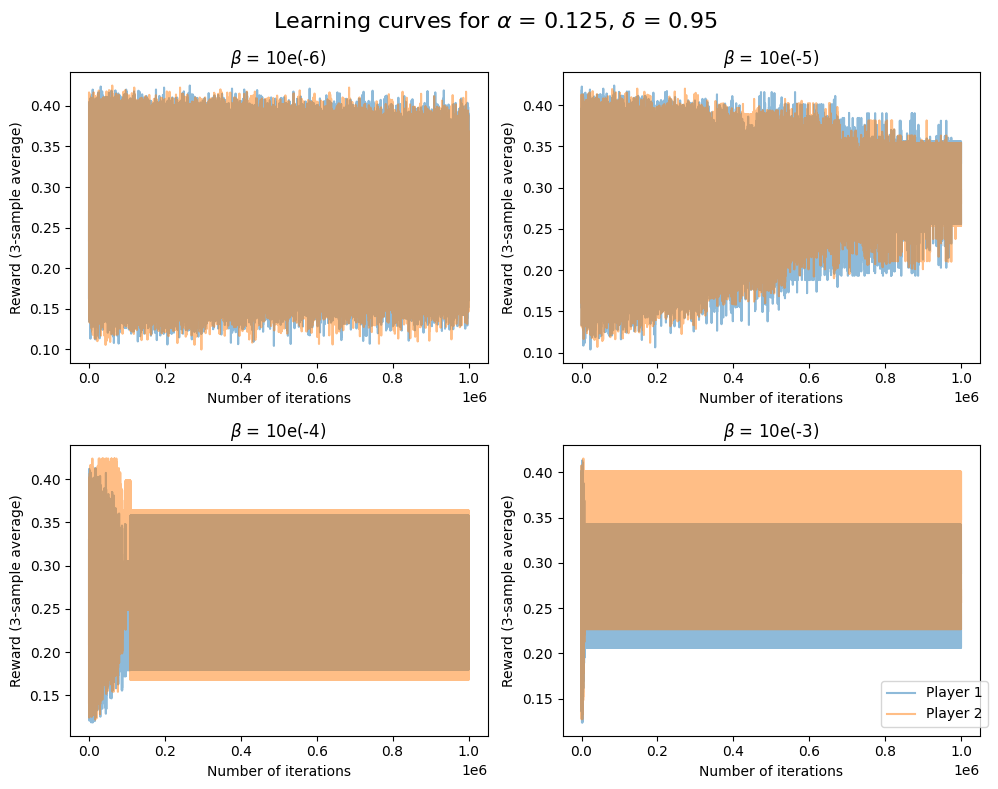

In [9]:
# Créer une figure et des sous-graphiques (3 lignes, 2 colonnes)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

line1, = axes[0, 0].plot(aggregated_agent1[0], alpha=0.5, label = 'Player 1')
line2, = axes[0, 0].plot(aggregated_agent2[0], alpha=0.5, label = 'Player 2')
axes[0, 0].set_title('$\\beta$ = 10e(-6)')

axes[0, 1].plot(aggregated_agent1[1], alpha=0.5, label = 'Player 1')
axes[0, 1].plot(aggregated_agent2[1], alpha=0.5, label = 'Player 2')
axes[0, 1].set_title('$\\beta$ = 10e(-5)')

axes[1, 0].plot(aggregated_agent1[2], alpha=0.5, label = 'Player 1')
axes[1, 0].plot(aggregated_agent2[2], alpha=0.5, label = 'Player 2')
axes[1, 0].set_title('$\\beta$ = 10e(-4)')

axes[1, 1].plot(aggregated_agent1[3], alpha=0.5, label = 'Player 1')
axes[1, 1].plot(aggregated_agent2[3], alpha=0.5, label = 'Player 2')
axes[1, 1].set_title('$\\beta$ = 10e(-3)')


lines = [line1, line2]
labels = ['Player 1', 'Player 2']
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(1,0.15))

# Nommer les axes (identique pour tous les sous-graphiques)
for ax in axes.flat:
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Reward (3-sample average)')

# Titre général de la figure
fig.suptitle('Learning curves for $\\alpha$ = 0.125, $\\delta$ = 0.95', fontsize=16)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

In [4]:
RN = 0.23
RM = 0.34
Rmean1 = np.zeros(4)
Rmean2 = np.zeros(4)
DRmean1 = np.zeros(4)
DRmean2 = np.zeros(4)
for i in range (len(aggregated_agent1)): 
    Rmean1[i] = aggregated_agent1[i][-100:].mean() 
    Rmean2[i] = aggregated_agent2[i][-100:].mean()
    DRmean1[i] = (Rmean1[i] - RN)/(RM - RN) 
    DRmean2[i] = (Rmean2[i] - RN)/(RM - RN) 
print(DRmean1)
print(DRmean2)

[0.27832157 0.64954011 0.34176604 0.42844119]
[0.25726004 0.71077058 0.28760377 0.83865606]


[0.26779081 0.68015534 0.31468491 0.63354863]


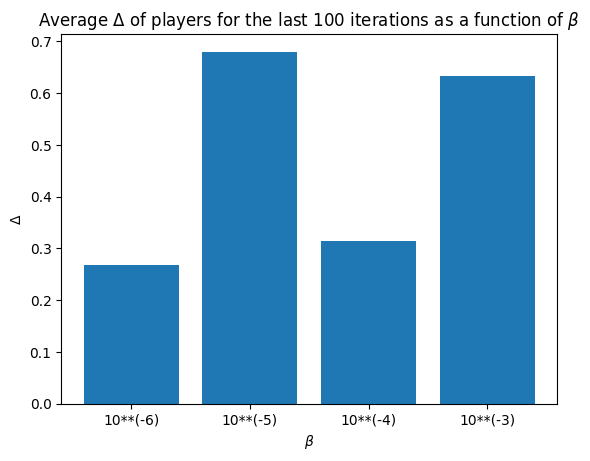

In [7]:
DRmean12 = [DRmean1,DRmean2]
DRmean = np.mean(DRmean12, axis=0)
print(DRmean)
plt.bar(['10**(-6)','10**(-5)','10**(-4)','10**(-3)'],DRmean)
plt.xlabel('$\\beta$')
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations as a function of $\\beta$')
plt.show()